# Twitter Dog Rating Project

**In this project we will be gethering, assessing and cleaning twitter data from the Twitter user @dog_rates otherwise known as WeRateDogs.  The data will come from 3 different sources**

### Data Sources

1. A .csv file called **twitter_archive_enhanced.csv**, which is provided by Udacity, this is an archive of 5000+ tweets from WeRateDogs as they stood on August 1, 2017.

2. A .tsv that will we will have to get from a URL with the requests library called **image_predictions.tsv**.  This contains image predictions for what breed of dog is present in each tweet according to a neural network.

3. Each tweets retweet count and favorite count and any addition fields that are intersting using the tweet IDs from the **twitter_archive_enhanced.csv**.  We will used the tweepy library to get these and store them in a text file called **tweet_json.txt**.

**This project will be broken out into 4 sections**

### Project Sections

1. Gather - We will gather the data from the 3 different sources.

2. Assess - We will assess any issues with the data and by examining it with code.

3. Clean - Based on our assessments we will clean the data and organize it into master .csv file called **twitter_archive_master.csv**.

4. Analysis - After we have a clean dataset we will examine it and record a insights and create visualizations based on it.

**Note: These steps are iterative, meaning we could discover something in later steps that might make it necessary for us to go back to previous steps.  For the purpose of the this project we are going to break them out into sections and do the majority of gathering, assessing, cleaning and analysis in their seperate sections, but some of the steps could be intermingled.**


In [1]:
##Importing the relevant modules
import pandas as pd
import numpy as np
import requests
import tweepy
## I saved my credentials to a seperate .py file called credentials
from credentials import *
import json



## Gather

In [2]:
##Get the first file mentioned

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')


In [3]:
##Get the second file
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_predictions.tsv','w') as file:
    file.write(r.text)
    
image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')



**Note: I saved my credentials in credentials.py file that I added to my notebook.  Once I create the initial json file I will remove those credentials from the .py file.**

In [4]:
##some testing with a single id

test_id = twitter_archive['tweet_id'][1]


**We are going to run a few tests with a single id and then we are going to load the json file.**

**We are going to create the tweet_json.txt file with the ._json [method](https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json).**


In [5]:
##Get the third json file
## first we need to establish a connection with the api

try:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

    tweet = api.get_status(id = test_id, tweet_mode = 'extended')
##Test it on our 1 example, we are going to get the retweet_count, the favorite_count, the full_test and the media
##For the media we are particularly interested in the media_url, because we want to do something interesting with the 
##photos for some of these tweets


    print(tweet.retweet_count, tweet.favorite_count, tweet.full_text, tweet.entities['media'][0])
    ##Opening the file
    with open('tweet_json.txt','w') as jsonfile:
        counter = 0
        ##looping through each tweet_id
        for tweet_id in twitter_archive['tweet_id']: 
            try:           
                tweet = api.get_status(id = tweet_id, tweet_mode = 'extended')
                json_str = json.dumps(tweet._json)
                ##making sure each json str goes on a new line
                
            except Exception as e:
                ##if we can't get something mark it as error and record it in json format
                print(e)
                json_str = json.dumps({"id":int(tweet_id),"error":str(e)})
                
            ##making sure each json str goes on a new line
            jsonfile.write('{}\n'.format(json_str))
            ##so i can tell how much we have left
            counter+= 1
            if counter in [500,1000,1500,2000]:
                print(counter, json_str)
except Exception as e:
    print('Our credentials have been removed: {}.'.format(e))

    

Our credentials have been removed: [{'code': 215, 'message': 'Bad Authentication data.'}].


**Now we have all our json data is in tweet_json.txt.  We are going to parse out that json and take a few new fields and add it to a seperate dataframe.**

**Based on what we looked at before we are going to load the dataframe with 5 fields.**

1. tweet_id (id in the json)
2. retweet_count (retweet_count in the json)
3. favorite_count (favorite_count in the json)
4. type of media (entities>media>type in the json)
5. url of media (entities>media>media_url_https in the json)
6. errors (error in the json)

In [6]:
#create an empty list
tweet_dict_list = []
with open('tweet_json.txt','r') as jsonfile:
    for line in jsonfile:
        tweet_dict = {}
        data =json.loads(line)
        try:
            tweet_dict['id'] = data['id']
            tweet_dict['retweet_count'] = data['retweet_count']
            tweet_dict['favorite_count'] = data['favorite_count']
            ##In case there isn't any media
            try:
                tweet_dict['media_type'] = data['entities']['media'][0]['type']
                tweet_dict['media_url'] = data['entities']['media'][0]['media_url_https']
            except:
                tweet_dict['media_type'] = np.nan
                tweet_dict['media_url'] = np.nan
        ##Catching any errors
        except Exception as e:
           
            tweet_dict['id'] = data['id']
            tweet_dict['error'] = data['error']

        tweet_dict_list.append(tweet_dict)

tweet_info = pd.DataFrame(tweet_dict_list)
tweet_info.to_csv('tweet_info.csv',index = False)
tweet_info.head()

,error,favorite_count,id,media_type,media_url,retweet_count
0,NaN,38439.0,892420643555336193,photo,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,8453.0
1,NaN,32935.0,892177421306343426,photo,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,6227.0
2,NaN,24815.0,891815181378084864,photo,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,4127.0
3,NaN,41797.0,891689557279858688,photo,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,8582.0
4,NaN,39961.0,891327558926688256,photo,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,9310.0


**There we have gathered all our data into 3 dataframes, tweet_info, image_predictions and twitter_archive, now it is time for our assessments**

## Assess

**One thing I notice right off the bat looking at tweet_info is that the retweet_count and favorite_count have .0s at the end, which means they are stored as floats.  I will note it here.  Since we started with tweet_info we will start with that for our assessment**

### tweet_info dataframe

#### Quality
- Favorite_count and retweet_count stored as floats (should be ints) - Dimension: Validity

In [7]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
error             15 non-null object
favorite_count    2341 non-null float64
id                2356 non-null int64
media_type        2067 non-null object
media_url         2067 non-null object
retweet_count     2341 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 110.5+ KB


**We discovered we have missing data for favorite_count and retweet_count, we also see that we do not have media for every single record.  These are both quality issues as data is missing, but we will need to address them in different ways**

#### Quality

- Data is missing for favorite_count and retweet_count - Dimension: Completeness
- Data is missing for media_type and media_url - Dimension: Completeness

In [8]:
##lets look at the null values
tweet_info[tweet_info['error'].notnull()]

,error,favorite_count,id,media_type,media_url,retweet_count
19,"[{'code': 144, 'message': 'No status found wit...",NaN,888202515573088257,NaN,NaN,NaN
95,"[{'code': 144, 'message': 'No status found wit...",NaN,873697596434513921,NaN,NaN,NaN
101,"[{'code': 34, 'message': 'Sorry, that page doe...",NaN,872668790621863937,NaN,NaN,NaN
118,"[{'code': 144, 'message': 'No status found wit...",NaN,869988702071779329,NaN,NaN,NaN
132,"[{'code': 144, 'message': 'No status found wit...",NaN,866816280283807744,NaN,NaN,NaN
155,"[{'code': 144, 'message': 'No status found wit...",NaN,861769973181624320,NaN,NaN,NaN
247,"[{'code': 144, 'message': 'No status found wit...",NaN,845459076796616705,NaN,NaN,NaN
260,"[{'code': 144, 'message': 'No status found wit...",NaN,842892208864923648,NaN,NaN,NaN
298,"[{'code': 144, 'message': 'No status found wit...",NaN,837012587749474308,NaN,NaN,NaN
382,"[{'code': 144, 'message': 'No status found wit...",NaN,827228250799742977,NaN,NaN,NaN


**The above looks like a tidiness issue, it looks like there are multiple variables in the error column. Code and message.  Another issue with the tidiness is that the errors look like a different observational unit and should likely be stored in a different dataframe/table.**

#### Tidiness

- Multiple variables stored in one column. (Each variable forms a column)
2. Code and message is a different observational unit than the rest of the data. (Each type of observanal unit forms a table)

In [9]:
##Lets look at a sample

tweet_info.sample(20)

,error,favorite_count,id,media_type,media_url,retweet_count
1646,NaN,2780.0,683834909291606017,photo,https://pbs.twimg.com/ext_tw_video_thumb/68383...,1201.0
907,NaN,7369.0,757741869644341248,photo,https://pbs.twimg.com/media/CoQKNY7XYAE_cuX.jpg,3565.0
75,NaN,7690.0,878281511006478336,photo,https://pbs.twimg.com/media/DDBIX9QVYAAohGa.jpg,1285.0
1010,NaN,4114.0,747461612269887489,photo,https://pbs.twimg.com/media/Cl-EXHSWkAE2IN2.jpg,1125.0
2330,NaN,773.0,666362758909284353,photo,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,567.0
781,NaN,13905.0,775729183532220416,photo,https://pbs.twimg.com/media/CsPxk85XEAAeMQj.jpg,5054.0
164,NaN,16963.0,860184849394610176,photo,https://pbs.twimg.com/media/C-_9jWWUwAAnwkd.jpg,6012.0
836,NaN,5093.0,767884188863397888,photo,https://pbs.twimg.com/media/CqgSl2tXgAADcaE.jpg,1546.0
1611,NaN,10066.0,685325112850124800,photo,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,4336.0
2247,NaN,643.0,667873844930215936,photo,https://pbs.twimg.com/media/CUTDtyGXIAARxus.jpg,419.0


In [10]:
tweet_info.describe()

,favorite_count,id,retweet_count
count,2341.000000,2.356000e+03,2341.000000
mean,8035.714225,7.427716e+17,2976.169586
std,12366.916413,6.856705e+16,4986.041969
min,0.000000,6.660209e+17,0.000000
25%,1391.000000,6.783989e+17,598.000000
50%,3505.000000,7.196279e+17,1393.000000
75%,9869.000000,7.993373e+17,3473.000000
max,164439.000000,8.924206e+17,84545.000000


**Looking at the above I do not see much else wrong with the dataset.  We will go ahead and move on to the twitter_archive dataframe**

### twitter_archive dataframe

In [11]:
##I want to see the full column
pd.options.display.max_colwidth = 500
twitter_archive.head()



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


**I am seeing a few issues right away just looking at the top of this data frame**

#### Quality

- There are quite a few missing values for for several of the fields for in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp. (Completeness)

- The expanded url column has a duplicate url that is comma seperated in row 4. (Consistency/Validity)

- The source column has some info about the URL but it really seems like the data should store the tag that says Twitter for Iphone (Consistency/Validitty)

- We are not sure what the last four columns mean (doggo, floofer, pupper, puppo). (Accuracy, validity) 

#### Tidiness

- Each bit of text contains a link at the end of it.  It would be better to store the tiny link seperate or remove it all together as it is not really text and is a URL. (Each variable forms a column)

**We will explore some of these issues a bit more to confirm if they are actually issues programatically**

In [12]:
##First lets confirm the above, the source column.
twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

**Confirmed our issue with the source column, it needs to be a category and it would better if we parsed out that category so it is easier to read**

**Now lets look at the info**

In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

**We have uncovered a few more possible Quality issues.**

#### Quality

- Do not have expanded urls for all observations (Completeness)
- It appears the timestamp column is not in a timestamp format (Validity)
- Not only do in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id have lots of null values they are stored in the float datatype when these are really integers (Validity)


In [14]:
pup_list= ['doggo','floofer','pupper','puppo']
twitter_archive[pup_list].describe()

,doggo,floofer,pupper,puppo
count,2356,2356,2356,2356
unique,2,2,2,2
top,None,None,None,None
freq,2259,2346,2099,2326


In [15]:
twitter_archive.groupby(pup_list).size()

doggo  floofer  pupper  puppo
None   None     None    None     1976
                        puppo      29
                pupper  None      245
       floofer  None    None        9
doggo  None     None    None       83
                        puppo       1
                pupper  None       12
       floofer  None    None        1
dtype: int64

**It appears the doggo,floofer,pupper and puppo should should just be True False columns.  We could combine them into 1 but I think more than 1 can occur in one observation so it might be better to keep them seperate**

**We have an idea that perhaps these columns are populated when the text mentions one of those four dog puns, so lets check a few**

In [16]:
twitter_archive[twitter_archive['pupper'] != 'None'][['text']+pup_list]

,text,doggo,floofer,pupper,puppo
29,This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox,None,None,pupper,None
49,This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would let steal my girl https://t.co/D43I96SlVu,None,None,pupper,None
56,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,None,None,pupper,None
78,RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,None,None,pupper,None
82,This is Ginger. She's having a ruff Monday. Too many pupper things going on. H*ckin exhausting. 12/10 would snug passionately https://t.co/j211oCDRs6,None,None,pupper,None
92,This is Jed. He may be the fanciest pupper in the game right now. Knows it too. 13/10 would sign modeling contract https://t.co/0YplNnSMEm,None,None,pupper,None
97,RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps:/…,None,None,pupper,None
98,This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ,None,None,pupper,None
107,This is Rover. As part of pupper protocol he had to at least attempt to eat the plant. Confirmed not tasty. Needs peanut butter. 12/10 https://t.co/AiVljI6QCg,None,None,pupper,None
132,"RT @dog_rates: This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7T…",None,None,pupper,None


**This confirms my assumption that these are checking for the dog puns, this is another quality issue**

**We understand what the column is and it looks accurate, but there are definitely validity issues since these are stored as strings when it would make more sense if they were booleans or 1 0 columns**

**We will revisit this in the cleaning step**



In [17]:
twitter_archive['tweet_id'].duplicated().sum()

0

**Good to know their are no duplicate ids in this data set.**

**Lets move on to the last dataset image_predictions**

### Image_predictions

In [18]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**Looking at the info this dataset already looks fairly clean I only see one possible quality issue**

#### Quality
- This dataset only has 2075 predictions, the twitter_archive had 2356, so we may be missing some values


In [19]:
image_predictions.sample(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
61,667152164079423490,https://pbs.twimg.com/media/CUIzWk_UwAAfUNq.jpg,1,toy_poodle,0.535411,True,Pomeranian,0.087544,True,miniature_poodle,0.062050,True
937,703611486317502464,https://pbs.twimg.com/media/CcO66OjXEAASXmH.jpg,1,Pembroke,0.756441,True,basenji,0.126621,True,Cardigan,0.080117,True
1296,752173152931807232,https://pbs.twimg.com/media/CnBBfNuWcAAkOgO.jpg,1,Labrador_retriever,0.527659,True,German_shepherd,0.174765,True,Chihuahua,0.045525,True
1898,850753642995093505,https://pbs.twimg.com/media/C8576jrW0AEYWFy.jpg,1,pug,0.996952,True,bull_mastiff,0.000996,True,French_bulldog,0.000883,True
146,668627278264475648,https://pbs.twimg.com/media/CUdw9thWsAA4mB9.jpg,1,French_bulldog,0.965403,True,pug,0.008604,True,Boston_bull,0.008004,True
389,673359818736984064,https://pbs.twimg.com/media/CVhBLohWEAAXtYl.jpg,1,English_setter,0.696568,True,Brittany_spaniel,0.104046,True,Ibizan_hound,0.034832,True
585,678991772295516161,https://pbs.twimg.com/media/CWxDaXHWsAAWV8W.jpg,1,Eskimo_dog,0.330216,True,Siberian_husky,0.187003,True,Chihuahua,0.101420,True
465,675006312288268288,https://pbs.twimg.com/media/CV4aqCwWsAIi3OP.jpg,1,boxer,0.654697,True,space_heater,0.043389,False,beagle,0.042848,True
839,694356675654983680,https://pbs.twimg.com/media/CaLZtmsWQAApbFw.jpg,1,hamster,0.429871,False,Pomeranian,0.144272,True,pretzel,0.127220,False
1360,761004547850530816,https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg,1,golden_retriever,0.735163,True,Sussex_spaniel,0.064897,True,Labrador_retriever,0.047704,True


**Looking at this dataset, I am realizing that we did not really need to pull the images.  This could be a quality issue since we have some duplicative data between the twitter_info and this dataset.  I will mark it down as such.**

#### Quality
- Duplicative data between image_predictions
- I also notice the the p1, p2, and p3 columns have lower case and capital values, it would be better to make them consistent (Consistency).


In [20]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


**Nothing else on this dataset stands out as particularly dirty.  The only thing I would want to add to the dataset is the actual breed of dog so we could see how it compares to the predicted breeds**

**Now on to the Cleaning phase**



## Cleaning

**In the cleaning phase we will go through each of 3 data sets and do the followings: **
- Summarize our assessments
- Define a plan to tackle each assessment detailing reasons why we are going to do it this way
- Tackle each assessment via python code
- Review the data sets overall and see if any data needs to be combined


### Twitter_info

#### Quality

- Favorite_count and retweet_count stored as floats (should be ints) - Dimension: Validity
- Data is missing for favorite_count and retweet_count - Dimension: Completeness

#### Define

**These first two go together, first I am going to convert the null values to 0s (will resolve the missing data).  Then I will change the columns to an integer type**

**Note: In the tidy section I will be removing the errors part of the dataframe so and just dropping the ones that were null so it is OK if i just make them 0 now**

#### Code

In [21]:
int_to_float = ['favorite_count', 'retweet_count']
for col in int_to_float:
    tweet_info[col].fillna(0, inplace = True)
    tweet_info[col] = tweet_info[col].astype(int)

##### Test

In [22]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
error             15 non-null object
favorite_count    2356 non-null int64
id                2356 non-null int64
media_type        2067 non-null object
media_url         2067 non-null object
retweet_count     2356 non-null int64
dtypes: int64(3), object(3)
memory usage: 110.5+ KB


- Data is missing for media_type and media_url - Dimension: Completeness

##### Define:

**To tackle this one we will need to look at some of the tweet data.  Then we will actually go to the twitter site and look at a few.  After we determine where we need to look we will have gather more data and populate it in our dataframe**

##### Code

**Note: Part of this code involves going back to the assessement and gathering phases so we can truly where we need to go to get our missing data**

In [23]:
tweet_info[tweet_info['media_type'].isnull()].sample(20)

,error,favorite_count,id,media_type,media_url,retweet_count
307,NaN,0,835685285446955009,NaN,NaN,8903
612,NaN,0,796904159865868288,NaN,NaN,9928
941,NaN,13484,752932432744185856,NaN,NaN,7467
654,NaN,0,791821351946420224,NaN,NaN,23439
893,NaN,1787,759446261539934208,NaN,NaN,535
188,NaN,356,855862651834028034,NaN,NaN,28
1505,NaN,8611,691793053716221953,NaN,NaN,4545
546,NaN,0,805823200554876929,NaN,NaN,8970
1443,NaN,2200,696744641916489729,NaN,NaN,1020
1349,NaN,1604,704134088924532736,NaN,NaN,505


In [24]:
##More assessment
sample_ids = tweet_info[tweet_info['media_type'].isnull()].sample(20)['id'].values

twitter_archive[twitter_archive['tweet_id'].isin(sample_ids)]




,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
110,871102520638267392,NaN,NaN,2017-06-03 20:33:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,NaN,NaN,NaN,https://twitter.com/animalcog/status/871075758080503809,14,10,None,doggo,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
234,847617282490613760,8.476062e+17,4.196984e+09,2017-03-31 01:11:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",.@breaannanicolee PUPDATE: Cannon has a heart on his nose. Pupgraded to a 13/10,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
269,841320156043304961,NaN,NaN,2017-03-13 16:08:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","We don't rate penguins, but if we did, this one would get 12/10 https://t.co/cEORXhwZ5K",NaN,NaN,NaN,https://twitter.com/abc/status/841311395547250688,12,10,None,None,None,None,None
404,824025158776213504,NaN,NaN,2017-01-24 22:44:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""I wish we were dogs"" 14/10 for @BadlandsNPS https://t.co/50qq2DItPW",NaN,NaN,NaN,https://twitter.com/badlandsnps/status/823966201328046080,14,10,None,None,None,None,None
479,815745968457060357,NaN,NaN,2017-01-02 02:26:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Say hello to Levi. He's a Madagascan Butterbop. One of the more docile Butterbops I've seen. 12/10 would give all the pets h…,7.914070e+17,4.196984e+09,2016-10-26 22:31:36 +0000,"https://twitter.com/dog_rates/status/791406955684368384/photo/1,https://twitter.com/dog_rates/status/791406955684368384/photo/1,https://twitter.com/dog_rates/status/791406955684368384/photo/1,https://twitter.com/dog_rates/status/791406955684368384/photo/1",12,10,Levi,None,None,None,None
529,808344865868283904,NaN,NaN,2016-12-12 16:16:49 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Seamus. He's very bad at entering pools. Still a very good boy tho 11/10 https://t.co/hfi264QwYM,NaN,NaN,NaN,https://vine.co/v/5QWd3LZqXxd,11,10,Seamus,None,None,None,None
589,799308762079035393,NaN,NaN,2016-11-17 17:50:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC BY HIS OWNER THIS IS SO WILD. 14/10 ULTIMATE LEGEND STATUS https://t.co/7oQ1wpf…,7.743144e+17,4.196984e+09,2016-09-09 18:31:54 +0000,"https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1",14,10,None,None,None,None,None
672,789903600034189313,NaN,NaN,2016-10-22 18:57:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Ralphy. His dreams were just shattered. Poor pupper. 13/10 it'll be ok Ralphy https://t.co/P0kSN6rT6H,NaN,NaN,NaN,https://vine.co/v/5wPT1aBxPQZ,13,10,Ralphy,None,None,pupper,None
749,779124354206535695,NaN,NaN,2016-09-23 01:04:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Hurley. He's the curly one. He hugs every other dog he see

**Looking at a few of the extended URLs it does look like there should be a media type and media value.  Lets take another look at the tweet_json.txt to see if we are missing anything.**

In [25]:
##record we visually confirmed had a photo
test_id = 871166179821445120

with open('tweet_json.txt') as r:
    for line in r:
        if json.loads(line)['id'] == test_id:
            print(line)

{"created_at": "Sun Jun 04 00:46:17 +0000 2017", "id": 871166179821445120, "id_str": "871166179821445120", "full_text": "RT @dog_rates: This is Dawn. She's just checking pup on you. Making sure you're doing okay. 12/10 she's here if you need her https://t.co/X\u2026", "truncated": false, "display_text_range": [0, 140], "entities": {"hashtags": [], "symbols": [], "user_mentions": [{"screen_name": "dog_rates", "name": "WeRateDogs\u2122", "id": 4196983835, "id_str": "4196983835", "indices": [3, 13]}], "urls": []}, "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>", "in_reply_to_status_id": null, "in_reply_to_status_id_str": null, "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "in_reply_to_screen_name": null, "user": {"id": 4196983835, "id_str": "4196983835", "name": "WeRateDogs\u2122", "screen_name": "dog_rates", "location": "\u21e9 merch \u21e9         DM YOUR DOGS", "description": "Your Only Source For Professional Dog Ratin

**Information looks like its there but there are multiple entities that we need to search through, since it is a retweet.  Lets try to extract it again.  With some manual checking we also know that quoted_statuses could store the information we need.**

**This is how we will gather the information that is missing**

In [26]:
media_list = []

##Need to use a recursive function to go through all the dictionaries. 
##After some troubleshooting we need to go to the retweeted status and quoted_status

def d_values(d, val):
    for key, value in d.items():
        if key == 'quoted_status':
            d2 = d[key]
            return d_values(d2, val)
        if key == 'retweeted_status':
            d2 = d[key]
            return d_values(d2, val)
        if key == 'entities':
            d2 = d[key] 
            return d_values(d2, val)

        elif key == 'media':
            d2 = d[key][0]
            return d_values(d2, val)
               
        elif key == val:
            return value
                
                  
          

missing_medias = tweet_info[(tweet_info['media_type'].isnull()) & (tweet_info['error'].isnull())]['id'].values
with open('tweet_json.txt', 'r') as jsonfile:
    for line in jsonfile:
        if json.loads(line)['id'] in missing_medias:
            media_dict = {}
            data = json.loads(line)
            media_dict['id'] = data['id']
            media_type = None
            media_url = None
            for key in data.keys():
                if key in ['entities', 'retweeted_status','quoted_status']:
                    media_type = d_values(data[key],'type')
                    media_url = d_values(data[key], 'media_url_https')
                if media_type == None or media_url == None:
                    continue
            media_dict['media_type'] = media_type
            media_dict['media_url'] = media_url
            media_list.append(media_dict)
            
media_list

##note need to use a recursive function

[{'id': 886267009285017600, 'media_type': None, 'media_url': None},
 {'id': 886054160059072513, 'media_type': None, 'media_url': None},
 {'id': 885518971528720385, 'media_type': None, 'media_url': None},
 {'id': 884247878851493888,
  'media_type': 'photo',
  'media_url': 'https://pbs.twimg.com/media/DER6EUbWAAEOY9Z.jpg'},
 {'id': 881633300179243008, 'media_type': None, 'media_url': None},
 {'id': 879674319642796034, 'media_type': None, 'media_url': None},
 {'id': 879130579576475649,
  'media_type': 'photo',
  'media_url': 'https://pbs.twimg.com/media/DC98vABUIAA97pz.jpg'},
 {'id': 878604707211726852, 'media_type': None, 'media_url': None},
 {'id': 878404777348136964,
  'media_type': 'photo',
  'media_url': 'https://pbs.twimg.com/media/DDBIX9QVYAAohGa.jpg'},
 {'id': 878316110768087041,
  'media_type': 'photo',
  'media_url': 'https://pbs.twimg.com/media/CUjETvDVAAI8LIy.jpg'},
 {'id': 876537666061221889,
  'media_type': 'photo',
  'media_url': 'https://pbs.twimg.com/media/DCjBmF-WAAAjvxb

**It looks like we are getting some of the image urls back for the retweeted images.  There are still some missing though. First, lets update the rows we have to see what we have left.**

In [27]:
def update_media(row):
    for data in media_list:
        if row['id'] == data['id']:
            row['media_type'] = data['media_type']
            row['media_url'] = data['media_url']
            break
    return row

##info to compare with our test
tweet_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
error             15 non-null object
favorite_count    2356 non-null int64
id                2356 non-null int64
media_type        2067 non-null object
media_url         2067 non-null object
retweet_count     2356 non-null int64
dtypes: int64(3), object(3)
memory usage: 110.5+ KB


##### Test

**The code below completes our update and tests how much records we have updated**

In [28]:
#creating copy
tweet_info_copy = tweet_info.copy()
#applying the update
tweet_info_copy = tweet_info_copy.apply(update_media, axis = 1)
##Looking at our info to see if it did update
tweet_info_copy.info()
##confirming 1 specific value updated
tweet_info_copy.query("id == 804475857670639616")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
error             15 non-null object
favorite_count    2356 non-null int64
id                2356 non-null int64
media_type        2164 non-null object
media_url         2164 non-null object
retweet_count     2356 non-null int64
dtypes: int64(3), object(3)
memory usage: 110.5+ KB


,error,favorite_count,id,media_type,media_url,retweet_count
551,NaN,6656,804475857670639616,photo,https://pbs.twimg.com/media/Cync8doUkAEt3t0.jpg,2237


**We were able to add 98 more media_types and media_urls.  There are still a few missing though lets take a look.  So far we have discovered that we need to check retweeted_status and quoted_status but there may be a few more.  Lets take a look at the value counts on the source.**

In [29]:
sample_ids = tweet_info_copy[tweet_info_copy['media_type'].isnull()]['id'].values

twitter_archive[twitter_archive['tweet_id'].isin(sample_ids)]['source'].value_counts()


<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>    98
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                       91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     3
Name: source, dtype: int64

**After spot checking the data we are fairly certain that Vines will not have a media_url and type like the other tweets, however we want to be sure we are checking all the correct tags when we try to find our image, so lets take a closer look at the other sources**

In [30]:
no_media = twitter_archive[twitter_archive['tweet_id'].isin(sample_ids)]
test_id = no_media[no_media['source'] !=  '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>']['tweet_id'].sample(1).iloc[0]

with open('tweet_json.txt', 'r') as jsonfile:
    for line in jsonfile:
        if json.loads(line)['id'] == test_id:
            print(json.loads(line))

{'created_at': 'Sun Dec 13 01:25:37 +0000 2015', 'id': 675849018447167488, 'id_str': '675849018447167488', 'full_text': 'This dog is being demoted to a 9/10 for not wearing a helmet while riding. Gotta stay safe out there. Thank you', 'truncated': False, 'display_text_range': [0, 111], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': 675845657354215424, 'in_reply_to_status_id_str': '675845657354215424', 'in_reply_to_user_id': 4196983835, 'in_reply_to_user_id_str': '4196983835', 'in_reply_to_screen_name': 'dog_rates', 'user': {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™', 'screen_name': 'dog_rates', 'location': '⇩ merch ⇩         DM YOUR DOGS', 'description': 'Your Only Source For Professional Dog Ratings IG, FB, Snapchat ⇨ WeRateDogs ⠀⠀ ⠀ ⠀⠀⠀ ⠀ Business: dogratingtwitter@gmail.com', 'url': 'https://t.co/N7sNNHAEXS', 'en

**After looking at a few random lines.  It is going to be difficult to get a valid image since many this are in response to articles that are linking other articles.  For now we are going to leave it as is with our 98 extra media_types and media_urls**

**We may change some of them (perhaps the vines) since we know the media source is actually the vine.  We will do that at the end once we clean the other datasets and assess if we need to combine them**

**Note: In the last few cells in order to properly clean the dataset we had to do some more gathering from our original datasource.  Data Wrangling is an iterative process so we may need to do that again later**

#### Tidiness

- Multiple variables stored in one column. (Each variable forms a column)
- Code and message is a different observational unit than the rest of the data. (Each type of observanal unit forms a table)

##### Define
**We will need to tackle these tidiness issues together.** 
 - First lets remove the errors from this data frame and store them in a seperate dataframe called "tweet_errors".
 - Then we will break out the columns of code and message into seperate columns
 - Then we will delete the original data fro tweet_errors
 - Then we will delete all the error columns from tweet_info_copy

#### Code

In [31]:
tweet_errors = tweet_info_copy[tweet_info_copy['error'].notnull()]
tweet_errors_copy = tweet_errors.copy()
##make sure json.loads can read it
tweet_errors_copy['error'] = tweet_errors["error"].str.replace('[','').str.replace(']','').str.replace("'",'"')

def col_func(row):
    error_dict = json.loads(row['error'])
    row['code'] = error_dict['code']
    row['message'] = error_dict['message']
    return row

tweet_errors_copy = tweet_errors_copy.apply(col_func, axis = 1)
tweet_errors_copy.head()

,error,favorite_count,id,media_type,media_url,retweet_count,code,message
19,"{""code"": 144, ""message"": ""No status found with that ID.""}",0,888202515573088257,NaN,NaN,0,144,No status found with that ID.
95,"{""code"": 144, ""message"": ""No status found with that ID.""}",0,873697596434513921,NaN,NaN,0,144,No status found with that ID.
101,"{""code"": 34, ""message"": ""Sorry, that page does not exist.""}",0,872668790621863937,NaN,NaN,0,34,"Sorry, that page does not exist."
118,"{""code"": 144, ""message"": ""No status found with that ID.""}",0,869988702071779329,NaN,NaN,0,144,No status found with that ID.
132,"{""code"": 144, ""message"": ""No status found with that ID.""}",0,866816280283807744,NaN,NaN,0,144,No status found with that ID.


**In the process we found one more quality issue the id columns not being consistent we will go ahead and update those in both dataframes to they are consistent with others**

**Note: In the cells below we are writing code to make our updates and immediately test then.**

##### Code/Test

In [32]:
##now drop all the columns we don't need

tweet_errors_final = tweet_errors_copy[['id','code','message']]
tweet_errors_final.reset_index(drop = True, inplace = True)
tweet_errors_clean = tweet_errors_final.rename(columns = {'id':'tweet_id'})

##We have our first clean dataset
tweet_errors_clean

,tweet_id,code,message
0,888202515573088257,144,No status found with that ID.
1,873697596434513921,144,No status found with that ID.
2,872668790621863937,34,"Sorry, that page does not exist."
3,869988702071779329,144,No status found with that ID.
4,866816280283807744,144,No status found with that ID.
5,861769973181624320,144,No status found with that ID.
6,845459076796616705,144,No status found with that ID.
7,842892208864923648,144,No status found with that ID.
8,837012587749474308,144,No status found with that ID.
9,827228250799742977,144,No status found with that ID.


**Now we wil remove the error columns and rows from the tweet_info_copy dataframe**

In [33]:
tweet_info_final = tweet_info_copy[tweet_info_copy['error'].isnull()]
tweet_info_final.reset_index(drop = True, inplace = True)
tweet_info_clean = tweet_info_final.drop(['error'], axis = 1).rename(columns = {'id':'tweet_id'})
tweet_info_clean.head()
tweet_info_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 5 columns):
favorite_count    2341 non-null int64
tweet_id          2341 non-null int64
media_type        2164 non-null object
media_url         2164 non-null object
retweet_count     2341 non-null int64
dtypes: int64(3), object(2)
memory usage: 91.5+ KB


**Now we are done cleaning tweet_info and we have two clean dataframes in its place**
- tweet_info_clean
- tweet_errors_clean

**We will continue with twitter_archive**

### Twitter_archive

#### Quality

- There are quite a few missing values for for several of the fields for in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp. (Completeness)

##### Define
**We only want to look at original tweets so lets drop these columns**

##### Code

In [34]:

twitter_archive_copy = twitter_archive.copy()
drop_vals = (twitter_archive[(twitter_archive['in_reply_to_status_id'].notnull()) | (twitter_archive['retweeted_status_id'].notnull())].index)
twitter_archive_copy.drop(drop_vals, axis = 0, inplace = True)

##test
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [35]:
twitter_archive_copy.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id',
                           'retweeted_status_timestamp'], axis = 1, inplace = True)

##test
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


- The expanded url column has a duplicate url that is comma seperated in row 4. (Consistency/Validity)

##### Define

 - We will split the expanded URL column by comma
 - We will check that the split values are the same
 - If they are we will replace the expanded URL column with the 1 url

##### Code/Test

In [36]:
twitter_archive[twitter_archive['expanded_urls'].str.count(',') >0].shape[0]

639

In [37]:

twitter_archive_copy['expanded_urls'].fillna('None', inplace = True)
twitter_archive_copy['urls'] = twitter_archive_copy['expanded_urls'].str.split(',')

twitter_archive_copy['fixed_urls'] = twitter_archive_copy['urls'].apply(lambda x: ','.join(set(x)) if len(x) > 1 else x[0])
twitter_archive_copy[twitter_archive_copy['fixed_urls'].str.count(',') > 0].shape[0]

28

**Looks like we removed almost 600 duplicates, lets fix the columns now**

**Also note we had to fill expanded_urls with 'None' in order to properly remove the duplicates.  This will be addressed in later cleaning exercise**

In [38]:
twitter_archive_copy['expanded_urls'] = twitter_archive_copy['fixed_urls']

twitter_archive_copy.drop(['urls','fixed_urls'], axis = 1, inplace = True)
twitter_archive_copy.head()


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12,10,Franklin,None,None,None,None


- The source column has some info about the URL but it really seems like the data should store the tag that says Twitter for Iphone (Consistency/Validitty)

##### Define

- We will first use regex to create the source_fixed columns
- We will check that is matches up with the old sources
- We will set the old source column to equal source_fixed
- We will drop the source_fixed columns

##### Code

In [39]:
twitter_archive_copy['source_fixed'] = twitter_archive_copy['source'].str.extract(r'>(?P<source_fixed>.+)<')

##test
twitter_archive_copy['source_fixed'].value_counts(), twitter_archive_copy.source.value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


(Twitter for iPhone     1964
 Vine - Make a Scene      91
 Twitter Web Client       31
 TweetDeck                11
 Name: source_fixed, dtype: int64,
 <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
 <a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
 <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
 <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
 Name: source, dtype: int64)

In [40]:
twitter_archive_copy['source'] = twitter_archive_copy['source_fixed']
twitter_archive_copy.drop(['source_fixed'], axis = 1, inplace = True)

twitter_archive_copy['source'] = twitter_archive_copy['source'].astype('category')
##test
twitter_archive_copy.info(),twitter_archive_copy['source'].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null category
text                  2097 non-null object
expanded_urls         2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: category(1), int64(3), object(8)
memory usage: 198.8+ KB


(None, 0    Twitter for iPhone
 1    Twitter for iPhone
 2    Twitter for iPhone
 3    Twitter for iPhone
 4    Twitter for iPhone
 Name: source, dtype: category
 Categories (4, object): [TweetDeck, Twitter Web Client, Twitter for iPhone, Vine - Make a Scene])

- We are not sure what the last four columns mean (doggo, floofer, pupper, puppo). (Accuracy, validity)

##### Define
**In our assessments we determined if that these were indicating whether or not a dog pun was present in the URL text**

- We will combine this columns into 1 column (dog_stage) using pd.melt


##### Code

In [41]:

twitter_archive_copy2 = twitter_archive_copy.copy()
twitter_archive_copy2 = pd.melt(twitter_archive_copy, id_vars = [col for col in twitter_archive_copy2.columns if col not in pup_list],
value_vars = pup_list, var_name = 'dog_stage_val', value_name = 'dog_stage')

##test
twitter_archive_copy2.info(), twitter_archive_copy2['dog_stage'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8388 entries, 0 to 8387
Data columns (total 10 columns):
tweet_id              8388 non-null int64
timestamp             8388 non-null object
source                8388 non-null object
text                  8388 non-null object
expanded_urls         8388 non-null object
rating_numerator      8388 non-null int64
rating_denominator    8388 non-null int64
name                  8388 non-null object
dog_stage_val         8388 non-null object
dog_stage             8388 non-null object
dtypes: int64(3), object(7)
memory usage: 655.4+ KB


(None, None       8041
 pupper      230
 doggo        83
 puppo        24
 floofer      10
 Name: dog_stage, dtype: int64)

**Now we need to drop the duplicates**

In [42]:
twitter_archive_copy2.drop('dog_stage_val', axis = 1, inplace = True)
twitter_archive_copy2.drop_duplicates(inplace = True)
##test
twitter_archive_copy2['dog_stage'].value_counts()

None       2097
pupper      230
doggo        83
puppo        24
floofer      10
Name: dog_stage, dtype: int64

**Still some duplicates left**

In [43]:
##group by the tweet_ids
g = twitter_archive_copy2.groupby('tweet_id')
##filter by having more than 1
dup_vals = list(g.filter(lambda x: len(x) > 1)['tweet_id'].values)
print(dup_vals[0])

twitter_archive_copy2.info()
index_drop = list(twitter_archive_copy2[(twitter_archive_copy2['tweet_id'].isin(dup_vals)) & (twitter_archive_copy2['dog_stage'] == 'None')].index)

twitter_archive_copy2.drop(index_drop, axis = 0, inplace = True)

##test
twitter_archive_copy2.info()


890240255349198849
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2444 entries, 0 to 7158
Data columns (total 9 columns):
tweet_id              2444 non-null int64
timestamp             2444 non-null object
source                2444 non-null object
text                  2444 non-null object
expanded_urls         2444 non-null object
rating_numerator      2444 non-null int64
rating_denominator    2444 non-null int64
name                  2444 non-null object
dog_stage             2444 non-null object
dtypes: int64(3), object(6)
memory usage: 190.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2108 entries, 0 to 7158
Data columns (total 9 columns):
tweet_id              2108 non-null int64
timestamp             2108 non-null object
source                2108 non-null object
text                  2108 non-null object
expanded_urls         2108 non-null object
rating_numerator      2108 non-null int64
rating_denominator    2108 non-null int64
name                  2108 non-null

**I dont know what the dog stages mean but there are some duplicates left lets check them out**

In [44]:
g = twitter_archive_copy2.groupby('tweet_id')
##filter by having more than 1
new_dup_vals = list(g.filter(lambda x: len(x) > 1)['tweet_id'].values)

twitter_archive_copy2[twitter_archive_copy2['tweet_id'].isin(new_dup_vals)].sort_values('tweet_id')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
897,733109485275860992,2016-05-19 01:38:16 +0000,Twitter for iPhone,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",https://twitter.com/dog_rates/status/733109485275860992/photo/1,12,10,None,doggo
5091,733109485275860992,2016-05-19 01:38:16 +0000,Twitter for iPhone,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",https://twitter.com/dog_rates/status/733109485275860992/photo/1,12,10,None,pupper
848,741067306818797568,2016-06-10 00:39:48 +0000,Twitter for iPhone,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,https://twitter.com/dog_rates/status/741067306818797568/photo/1,12,10,just,doggo
5042,741067306818797568,2016-06-10 00:39:48 +0000,Twitter for iPhone,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,https://twitter.com/dog_rates/status/741067306818797568/photo/1,12,10,just,pupper
748,751583847268179968,2016-07-09 01:08:47 +0000,Twitter for iPhone,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5,10,None,doggo
4942,751583847268179968,2016-07-09 01:08:47 +0000,Twitter for iPhone,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5,10,None,pupper
689,759793422261743616,2016-07-31 16:50:42 +0000,Twitter for iPhone,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",https://twitter.com/dog_rates/status/759793422261743616/photo/1,12,10,Maggie,doggo
4883,759793422261743616,2016-07-31 16:50:42 +0000,Twitter for iPhone,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",https://twitter.com/dog_rates/status/759793422261743616/photo/1,12,10,Maggie,pupper
562,781308096455073793,2016-09-29 01:42:20 +0000,Vine - Make a Scene,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",https://vine.co/v/5rgu2Law2ut,12,10,None,doggo
4756,781308096455073793,2016-09-29 01:42:20 +0000,Vine - Make a Scene,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",https://vine.co/v/5rgu2Law2ut,12,10,None,pupper


**Since we are not sure if these are doggos or puppers lets drop them from our analysis**

In [45]:
index_drop2 = list(twitter_archive_copy2[twitter_archive_copy2['tweet_id'].isin(new_dup_vals)].index)
twitter_archive_copy2.drop(index_drop2, axis = 0, inplace = True)

##test
twitter_archive_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 7158
Data columns (total 9 columns):
tweet_id              2086 non-null int64
timestamp             2086 non-null object
source                2086 non-null object
text                  2086 non-null object
expanded_urls         2086 non-null object
rating_numerator      2086 non-null int64
rating_denominator    2086 non-null int64
name                  2086 non-null object
dog_stage             2086 non-null object
dtypes: int64(3), object(6)
memory usage: 163.0+ KB


- Do not have expanded urls for all observations (Completeness)

##### Define

- We will do additional assessments on missing expanded url values.
- If needed we will gather more data
- Finally we will add the data to the dataframe

##### Code

In [46]:
##assessment
no_expanded_url = twitter_archive_copy2[twitter_archive_copy2['expanded_urls'] == 'None']
no_expanded_url

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
295,828361771580813312,2017-02-05 21:56:51 +0000,Twitter Web Client,Beebop and Doobert should start a band 12/10 would listen,None,12,10,None,None
538,785515384317313025,2016-10-10 16:20:36 +0000,Twitter for iPhone,"Today, 10/10, should be National Dog Rates Day",None,10,10,None,None
5416,696518437233913856,2016-02-08 02:18:30 +0000,Twitter for iPhone,Oh my god 10/10 for every little hot dog pupper,None,10,10,None,pupper


In [47]:
no_expanded_url['name'].value_counts()


None    3
Name: name, dtype: int64

In [48]:
##Lets just drop these
twitter_archive_copy2.drop(no_expanded_url.index, axis = 0, inplace = True)

##test
twitter_archive_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 7158
Data columns (total 9 columns):
tweet_id              2083 non-null int64
timestamp             2083 non-null object
source                2083 non-null object
text                  2083 non-null object
expanded_urls         2083 non-null object
rating_numerator      2083 non-null int64
rating_denominator    2083 non-null int64
name                  2083 non-null object
dog_stage             2083 non-null object
dtypes: int64(3), object(6)
memory usage: 162.7+ KB


**It looks like none of these have names asscoitated with them, they also look like they are mostly in reply to tweets.  We assessed manually by looking at the json for a few of these examples and I think it is fine to just leave them as the value 'None' since nothing was provided to us**

- It appears the timestamp column is not in a timestamp format (Validity)

##### Define

- We will just do a pd.to_datetime on the timestamp columns (timestamp and retweeted_status_timestamp)
- We might need to convert some of the null values to a np.datetime64('NaT')

##### Code


In [49]:
time_list = ['timestamp']

for col in time_list:
    twitter_archive_copy2[col] = pd.to_datetime(twitter_archive_copy2[col])
    
##test

twitter_archive_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 7158
Data columns (total 9 columns):
tweet_id              2083 non-null int64
timestamp             2083 non-null datetime64[ns]
source                2083 non-null object
text                  2083 non-null object
expanded_urls         2083 non-null object
rating_numerator      2083 non-null int64
rating_denominator    2083 non-null int64
name                  2083 non-null object
dog_stage             2083 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 162.7+ KB


- Not only do in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id have lots of null values they are stored in the float datatype when these are really integers (Validity)

##### Define
**We removed these already so we dont need to do anything here**

#### Tidiness

- Each bit of text contains a link at the end of it. It would be better to store the tiny link seperate or remove it all together as it is not really text and is a URL. (Each variable forms a column)

##### Define

- We want to move the short urls out of the text as they are not the actual text of the tweet.
- First we are going to create a short_url field called with str.extract
- Then we are going to remove the urls from the text

In [50]:
twitter_archive_copy2['short_url'] = twitter_archive_copy2['text'].str.extract(r'(?P<short_url>https:\S+\s*)')
twitter_archive_copy2['short_url'].describe()
twitter_archive_copy2[['text','short_url']].sample(20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


,text,short_url
1084,This is Keurig. He's a rare dog. Laughs like an idiot tho. Head is basically a weapon. Poorly maintained goatee 4/10 https://t.co/xOrUyj7K30,https://t.co/xOrUyj7K30
1301,"""I'm the only one that ever does anything in this household"" 10/10 https://t.co/V8HcVIh4jt",https://t.co/V8HcVIh4jt
1845,This is Jeffrie. He's a handheld pup. Excellent ears. Super fluffy. 10/10 overall topnotch canine https://t.co/SWnrQAFOtt,https://t.co/SWnrQAFOtt
961,This is Harnold. He accidentally opened the front facing camera. 10/10 get it together Harnold https://t.co/S6JHaSMtln,https://t.co/S6JHaSMtln
4789,This is Sampson. He's about to get hit with a vicious draw 2. Has no idea. 11/10 poor pupper https://t.co/FYT9QBEnKG,https://t.co/FYT9QBEnKG
31,This is Maisey. She fell asleep mid-excavation. Happens to the best of us. 13/10 would pat noggin approvingly https://t.co/tp1kQ8i9JF,https://t.co/tp1kQ8i9JF
646,This is Louie. He's making quite a h*ckin mess. Doesn't seem to care. 12/10 jubilant af https://t.co/Z2g2YWPzX2,https://t.co/Z2g2YWPzX2
1816,Say hello to Clarence. He's a western Alkaline Pita. Very proud of himself for dismembering his stuffed dog pal 8/10 https://t.co/BHxr9O7wJY,https://t.co/BHxr9O7wJY
836,"For anyone who's wondering, this is what happens after a doggo catches it's tail... 11/10 https://t.co/G4fNhzelDv",https://t.co/G4fNhzelDv
1062,Meet Malikai. He was rolling around having fun when he remembered the inevitable heat death of the universe. 10/10 https://t.co/Vd2FqHIIGn,https://t.co/Vd2FqHIIGn


In [51]:
twitter_archive_final = twitter_archive_copy2.copy()
twitter_archive_final['text'] = twitter_archive_copy2['text'].str.replace('https:\S+\s*','')
##test
twitter_archive_final['text'].sample(20)

500                                   When she says you're a good boy and you know you're a good boy because you're a good boy. 13/10 
1611                                         Seriously guys?! Only send in dogs. I only rate dogs. This is a baby black bear... 11/10 
164     This is Rumpole. He'll be your Uber driver this evening. Won't start driving until you buckle pup. 13/10 h*ckin safe good boy 
445                                                                          This is Milo. I would do terrible things for Milo. 13/10 
611                This is Bungalo. She uses that face to get what she wants. It works unbelievably well. 12/10 would never say no to 
1166                                                                                        This is Dotsy. She's stuck as hell. 10/10 
1982                     This is Alfie. He's that one hypocritical gym teacher who made you run laps. Great posture. Cool bench. 6/10 
929                           When you're trying to enj

In [52]:
twitter_archive_clean = twitter_archive_final.copy()

**Now we have another clean dataframe twitter_archive_clean.  Just a note here, some of the short_urls we pulled are not actually complete.  For the purposes of this analysis we are going to leave them that way but just wanted to note that here.  Now to move on image_predictions.**

### Image_predictions

#### Quality

- This dataset only has 2075 predictions, the twitter_archive had 2356, so we may be missing some values

##### Define

**We can do much about the missing predictions so in this case we won't fix this issue**

- I also notice the the p1, p2, and p3 columns have lower case and capital values, it would be better to make them consistent (Consistency).

##### Define
- We will convert all values in p1, p2, p3 to lower case str.lower()

##### Code

In [53]:
lower_list = ['p1','p2','p3']

image_predictions_copy = image_predictions.copy()
image_predictions_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [54]:
for col in lower_list:
    image_predictions_copy[col] = image_predictions_copy[col].str.lower()
    
##test
image_predictions_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


- Duplicative data between image_predictions

#### Define

**After going through the dataframes it is ok if we have image data in our main dataframe and image data in this one.  We are going to leave as is**


In [55]:
image_predictions_clean = image_predictions_copy

### Cleaning Summary

**Going over all our dataframes, our goal is going to be to tidy them all up into a sqllite database.  We are going to load that database with 3 tables (we will also have .csvs for each one too).**

- table: dog_twitter_archive, text: twitter_archive_enhanced.csv - For this table we are going to combine the tweet_info_clean with twitter_archive_clean and add some additional fields so we can tell if the tweet has a prediction or has errors.

- table: dog_twitter_predictions text: image_predictions.tsv - This will just be image_predictions_clean dataframe

- table: dog_twitter_errors text: twitter_errors.csv - This will just be the errors that we received

In [56]:
## Lets create the easy tables first

import sqlite3

tweet_errors_clean.to_csv('twitter_errors.csv', index = False)

db_file = 'dog_twitter.db'

conn = sqlite3.connect(db_file)
tweet_errors_clean.set_index('tweet_id').to_sql('dog_twitter_errors', conn, if_exists = 'replace', index = True)
image_predictions_clean.set_index('tweet_id').to_sql('dog_twitter_predictions', conn, if_exists = 'replace', index = True)

In [57]:
##test
test_df = pd.read_sql("select * from dog_twitter_errors", conn)
test_df.head()

,tweet_id,code,message
0,888202515573088257,144,No status found with that ID.
1,873697596434513921,144,No status found with that ID.
2,872668790621863937,34,"Sorry, that page does not exist."
3,869988702071779329,144,No status found with that ID.
4,866816280283807744,144,No status found with that ID.


In [58]:
##to create a final enhanced archive

twitter_archive_enhanced = twitter_archive_clean.merge(tweet_info_clean, how = 'left', on = 'tweet_id')

twitter_archive_enhanced.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 2082
Data columns (total 14 columns):
tweet_id              2083 non-null int64
timestamp             2083 non-null datetime64[ns]
source                2083 non-null object
text                  2083 non-null object
expanded_urls         2083 non-null object
rating_numerator      2083 non-null int64
rating_denominator    2083 non-null int64
name                  2083 non-null object
dog_stage             2083 non-null object
short_url             2083 non-null object
favorite_count        2082 non-null float64
media_type            1980 non-null object
media_url             1980 non-null object
retweet_count         2082 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 244.1+ KB


**I also want to add two new columns to show if there is a prediction or there is an error.**

In [59]:
twitter_archive_enhanced['has_prediction'] = twitter_archive_enhanced['tweet_id'].isin(image_predictions_clean['tweet_id'].values)
twitter_archive_enhanced['has_error'] = twitter_archive_enhanced['tweet_id'].isin(tweet_errors_clean['tweet_id'].values)

#test
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 2082
Data columns (total 16 columns):
tweet_id              2083 non-null int64
timestamp             2083 non-null datetime64[ns]
source                2083 non-null object
text                  2083 non-null object
expanded_urls         2083 non-null object
rating_numerator      2083 non-null int64
rating_denominator    2083 non-null int64
name                  2083 non-null object
dog_stage             2083 non-null object
short_url             2083 non-null object
favorite_count        2082 non-null float64
media_type            1980 non-null object
media_url             1980 non-null object
retweet_count         2082 non-null float64
has_prediction        2083 non-null bool
has_error             2083 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 248.2+ KB


**Finally lets fill the nulls for the floats and convert the floats to int and save it to a clean dataframe**

In [60]:
##fill the NAs for the favorite and retweet_count
twitter_archive_enhanced[['favorite_count','retweet_count']] = twitter_archive_enhanced[['favorite_count','retweet_count']].fillna(0)

def float_to_int(df):
    for col in df.columns:
        if df[col].dtype == float:
            df[col] = df[col].astype(int)
    return df

twitter_archive_enhanced_clean = float_to_int(twitter_archive_enhanced)
##test
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 2082
Data columns (total 16 columns):
tweet_id              2083 non-null int64
timestamp             2083 non-null datetime64[ns]
source                2083 non-null object
text                  2083 non-null object
expanded_urls         2083 non-null object
rating_numerator      2083 non-null int64
rating_denominator    2083 non-null int64
name                  2083 non-null object
dog_stage             2083 non-null object
short_url             2083 non-null object
favorite_count        2083 non-null int64
media_type            1980 non-null object
media_url             1980 non-null object
retweet_count         2083 non-null int64
has_prediction        2083 non-null bool
has_error             2083 non-null bool
dtypes: bool(2), datetime64[ns](1), int64(5), object(8)
memory usage: 248.2+ KB


In [61]:
##finally lets save it to our database
twitter_archive_enhanced_clean.to_csv('twitter_archive_master.csv', index = False)
twitter_archive_enhanced_clean.set_index('tweet_id').to_sql('dog_twitter_archive', conn, if_exists = 'replace', index = True)

In [62]:
##test

pd.read_sql("select * from dog_twitter_archive", conn).head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,short_url,favorite_count,media_type,media_url,retweet_count,has_prediction,has_error
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,https://t.co/MgUWQ76dJU,38439,photo,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,8453,1,0
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,https://t.co/0Xxu71qeIV,32935,photo,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,6227,1,0
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,https://t.co/wUnZnhtVJB,24815,photo,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,4127,1,0
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,https://t.co/tD36da7qLQ,41797,photo,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,8582,1,0
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12,10,Franklin,None,https://t.co/AtUZn91f7f,39961,photo,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,9310,1,0


In [63]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)

,name
0,dog_reply_tos
1,dog_retweets
2,dog_twitter_errors
3,dog_twitter_predictions
4,dog_twitter_archive


### Cleaning Conclusion

**Overall we were able to resolve mutliple quality and tidiness issues and create a data base with 5 tables**

- dog_twitter_errors
- dog_twitter_predictions
- dog_reply_tos
- dog_retweets
- dog_twitter_archive



## Analysis
**Some initial questions.**
- Do the ratings correlate to higher retweet_count and favorite_count?
- What are the most popular words used to describe the dogs?
- What predicted dogs get the most retweets and favorites?

In [64]:
##import some other modules
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [65]:
## first lets add a new column for ratings.
dog_df = pd.read_sql("select * from dog_twitter_archive", conn)

##first need to make sure they denominators are not 0 so we can properly make the calculation
dog_df['rating_denominator'] = dog_df['rating_denominator'].apply(lambda x: 1 if x == 0 else x)

dog_df['overall_rating'] = dog_df['rating_numerator']/dog_df['rating_denominator']

dog_df['overall_rating'].describe()

count    2083.000000
mean        1.169651
std         3.979209
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: overall_rating, dtype: float64

**There is a huge outlier with 960 and it looks like the majority of values are between 1 and 2.  Lets remove the outlier and graph a histogram**

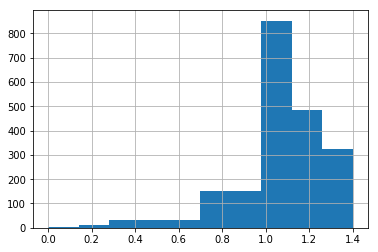

In [66]:
dog_df[dog_df['overall_rating']< 2]['overall_rating'].hist();

**Without the outlier we can see a slight left skew.  It looks like the mode is a little higher than the median as well**

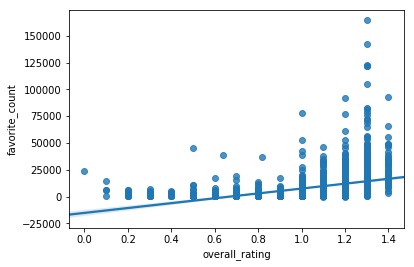

In [67]:
sns.regplot(x = 'overall_rating', y = 'favorite_count', data = dog_df[dog_df['overall_rating']< 2][['overall_rating', 'favorite_count']]);

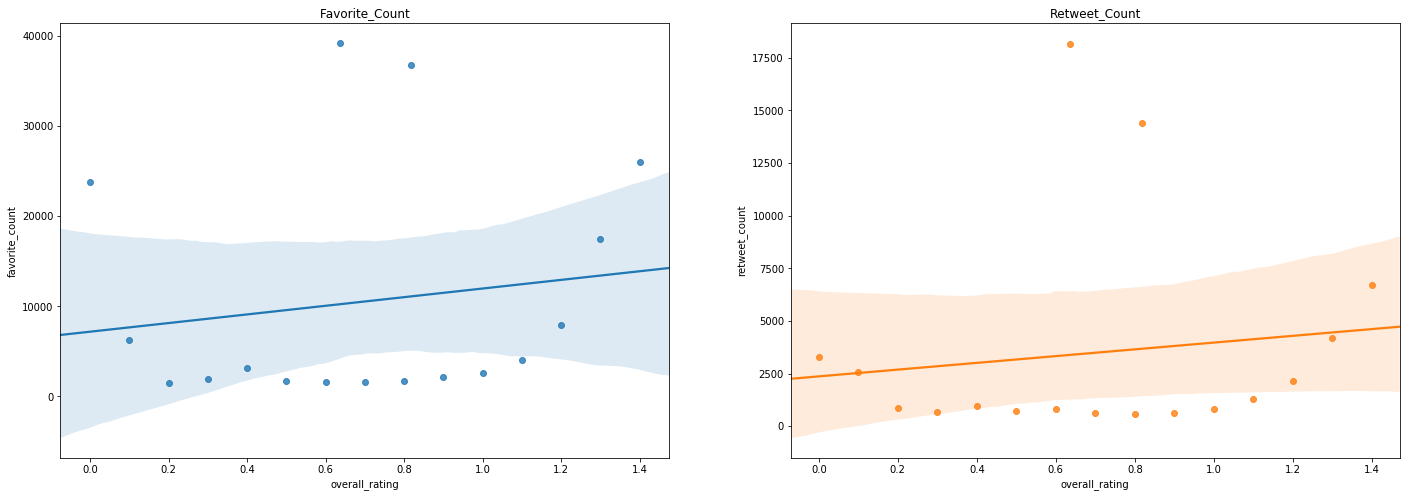

In [68]:
##Lets graph it with median ratings favorite_count per rating
def graph_median(df, column, ax):
    ##remove outliers
    df = df[df['overall_rating'] <2]
    data = df.groupby('overall_rating', as_index = False)[column].median()
    ax.set_title(column.title())
    sns.regplot(x = 'overall_rating', y = column, data = data, ax = ax);

fig, axes = plt.subplots(1,2, figsize = (24,8))

graph_median(dog_df, 'favorite_count', axes[0]), graph_median(dog_df, 'retweet_count', axes[1])
fig.savefig('overall_rating_vs_cnt.png')

**Conclusion 1: Overall Rating has little imact with median favorite count and retweet count**

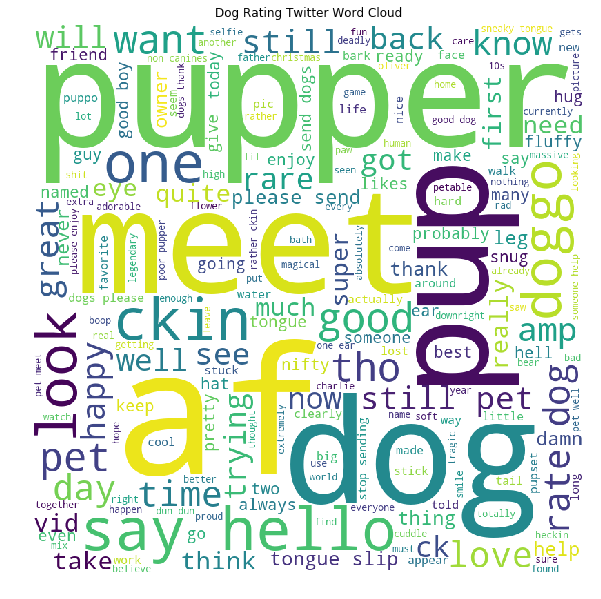

In [69]:
stopwords = set(STOPWORDS)

comments_words = ' '
for text in dog_df['text']:
    words = text.split()
    for i in range(len(words)):
        words[i] = words[i].lower()
    for word in words:
        comments_words = comments_words + word + ' '
        
wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comments_words)
    
fig1 = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Dog Rating Twitter Word Cloud")
fig1.savefig('word_cloud.png')
plt.show()

**Looks like based off this wordcloud the most popular words used are pupper, pup, meet and others, pupper makes sense since we know that over 200 pupper puns are present in the dataframe.  This could give us ideas on what other dog puns to record besides the ones we have**

In [70]:
sql = """SELECT t.tweet_id, t.favorite_count, t.retweet_count, s.p1
            FROM dog_twitter_archive t
            JOIN dog_twitter_predictions s
              ON t.tweet_id = s.tweet_id"""
pred_df = pd.read_sql(sql, conn)

pred_df['p1'].value_counts()[0:10]

golden_retriever      133
labrador_retriever     94
pembroke               88
chihuahua              78
pug                    54
chow                   41
samoyed                40
pomeranian             38
toy_poodle             37
malamute               29
Name: p1, dtype: int64

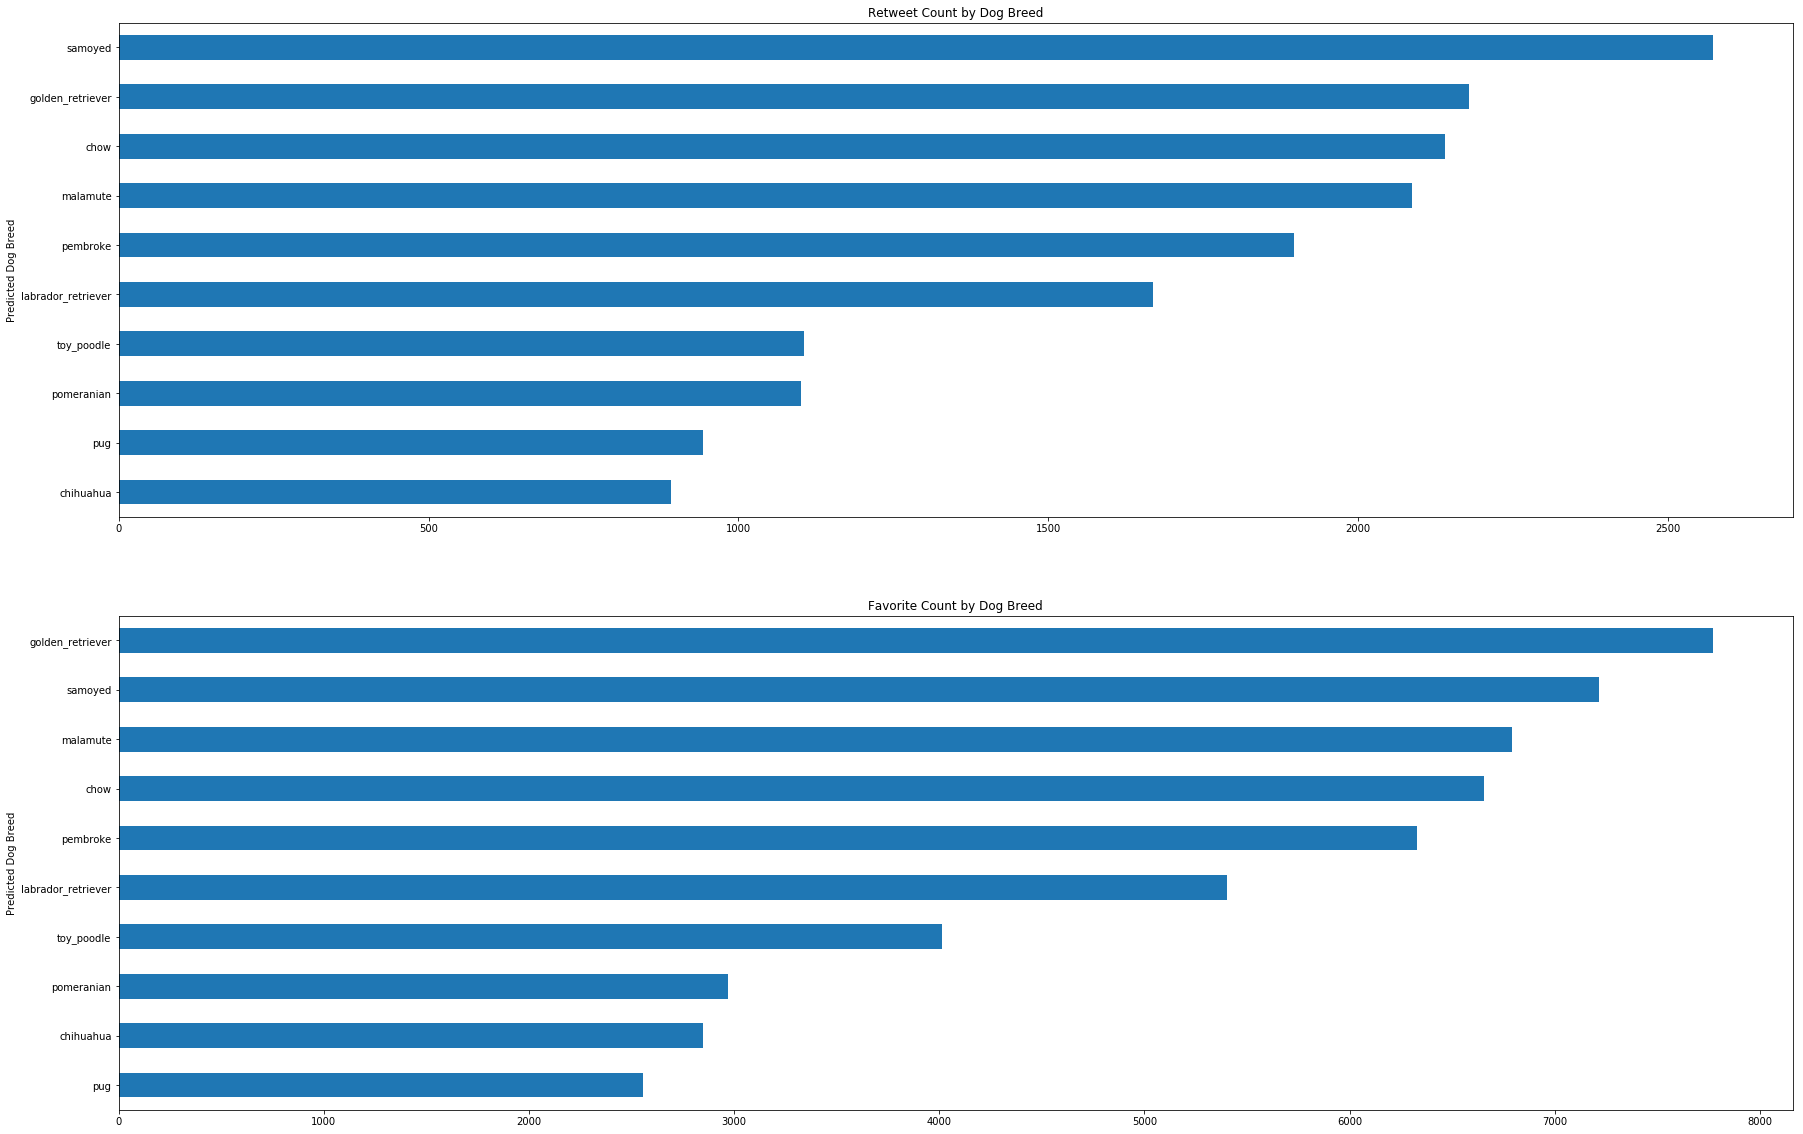

In [71]:
top10 = list(pred_df['p1'].value_counts()[0:10].index)

group = pred_df[pred_df['p1'].isin(top10)].groupby('p1')

fig3, (ax3, ax4) = plt.subplots(2,1, figsize=(30,20))
y_label = 'Predicted Dog Breed'

group['retweet_count'].median().sort_values(ascending = True).plot(kind = 'barh', ax = ax3, title = 'Retweet Count by Dog Breed')
group['favorite_count'].median().sort_values(ascending = True).plot(kind = 'barh', ax = ax4, title = 'Favorite Count by Dog Breed')
ax3.set_ylabel(y_label)
ax4.set_ylabel(y_label)
fig3.savefig('count_by_dogbred.png')
plt.show()

**It appears the samoyed, golden retrievers and chows usually get the most retweets and favorites based on the above**

### Final Conclusions

**In this project we did the following**

- We gathered data from different sources, (via twitter api, via requests and via data handed to us)
- We assessed the data for quality and tidiness issues.
- We examined the issues we found and addressed the important ones by cleaning the data.
- We organized the data into a tidy database with 5 tables
- We did some analysis on the tidy dataset and discovered a few insights on the data